In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from prophet import Prophet
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
from statsmodels.tsa.stattools import adfuller

2024-06-04 23:58:31.504338: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-04 23:58:31.504453: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-04 23:58:31.651497: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

In [3]:
df = pd.read_csv("/kaggle/input/apple-stock-price-from-19802021/AAPL.csv")
print("the head of the data is:")
print(df.head())
print("the tail of the data is:")
print(df.tail())

the head of the data is:
         Date      Open      High       Low     Close  Adj Close     Volume
0  1980-12-12  0.128348  0.128906  0.128348  0.128348   0.100178  469033600
1  1980-12-15  0.122210  0.122210  0.121652  0.121652   0.094952  175884800
2  1980-12-16  0.113281  0.113281  0.112723  0.112723   0.087983  105728000
3  1980-12-17  0.115513  0.116071  0.115513  0.115513   0.090160   86441600
4  1980-12-18  0.118862  0.119420  0.118862  0.118862   0.092774   73449600
the tail of the data is:
             Date        Open        High         Low       Close   Adj Close  \
10463  2022-06-13  132.869995  135.199997  131.440002  131.880005  131.880005   
10464  2022-06-14  133.130005  133.889999  131.479996  132.759995  132.759995   
10465  2022-06-15  134.289993  137.339996  132.160004  135.429993  135.429993   
10466  2022-06-16  132.080002  132.389999  129.039993  130.059998  130.059998   
10467  2022-06-17  130.070007  133.080002  129.809998  131.559998  131.559998   

       

In [4]:
# checking for the duplicate values
duplicate_dates = df[df.duplicated(['Date'])]
print("the duplicate dates are:")
print(duplicate_dates)
# checking for the missing values
missing_values = df.isnull().sum()
print("the missing values are:")
print(missing_values)

the duplicate dates are:
Empty DataFrame
Columns: [Date, Open, High, Low, Close, Adj Close, Volume]
Index: []
the missing values are:
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [5]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

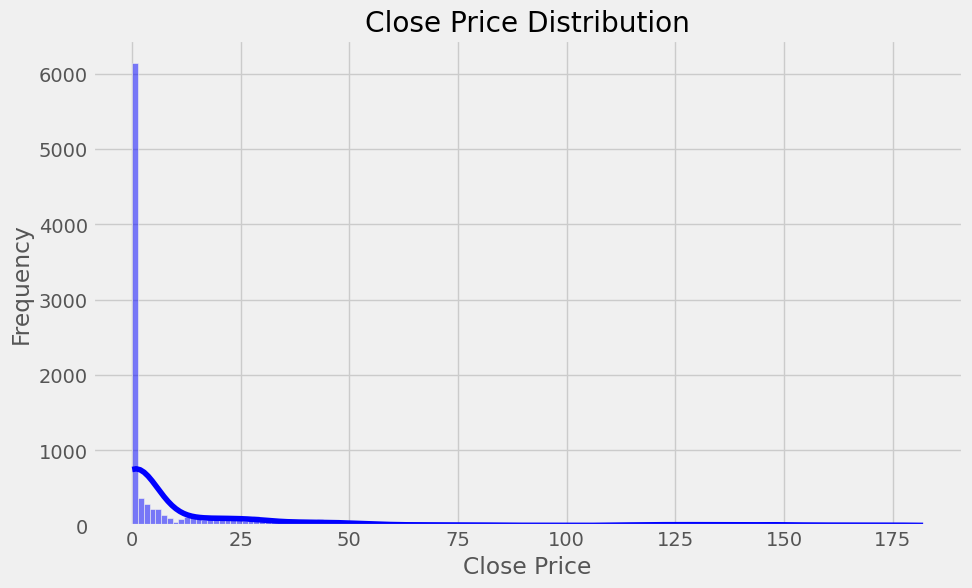

In [6]:
# the ditribution of close price
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.title('Close Price Distribution')
plt.xlabel('Close Price')
plt.ylabel('Frequency')
sns.histplot(df['Close'], kde=True, color='blue')
plt.show()

1. Indicates that the majority of the Close Prices are in the range of 0 to 35
2. Significant skewed to the right

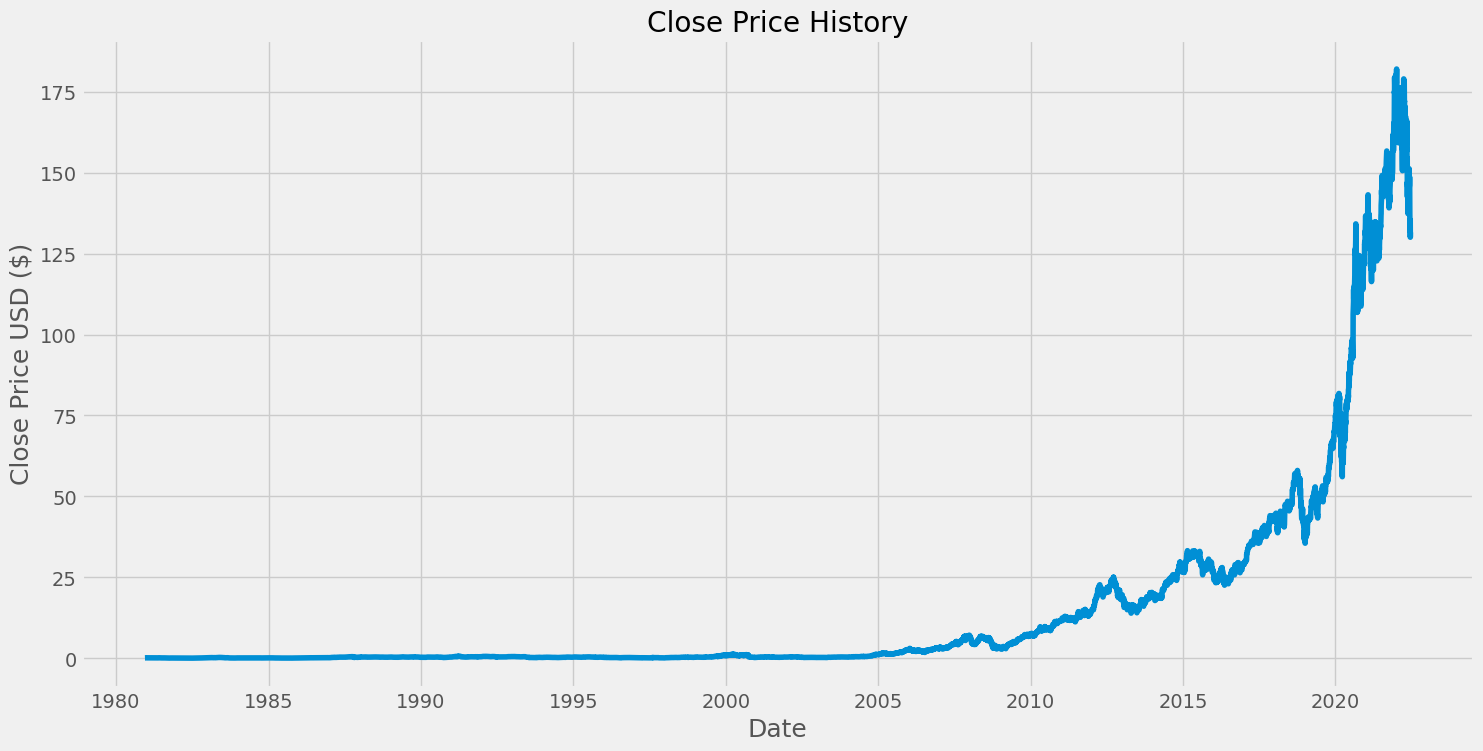

In [7]:
# let's plot the close price history
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

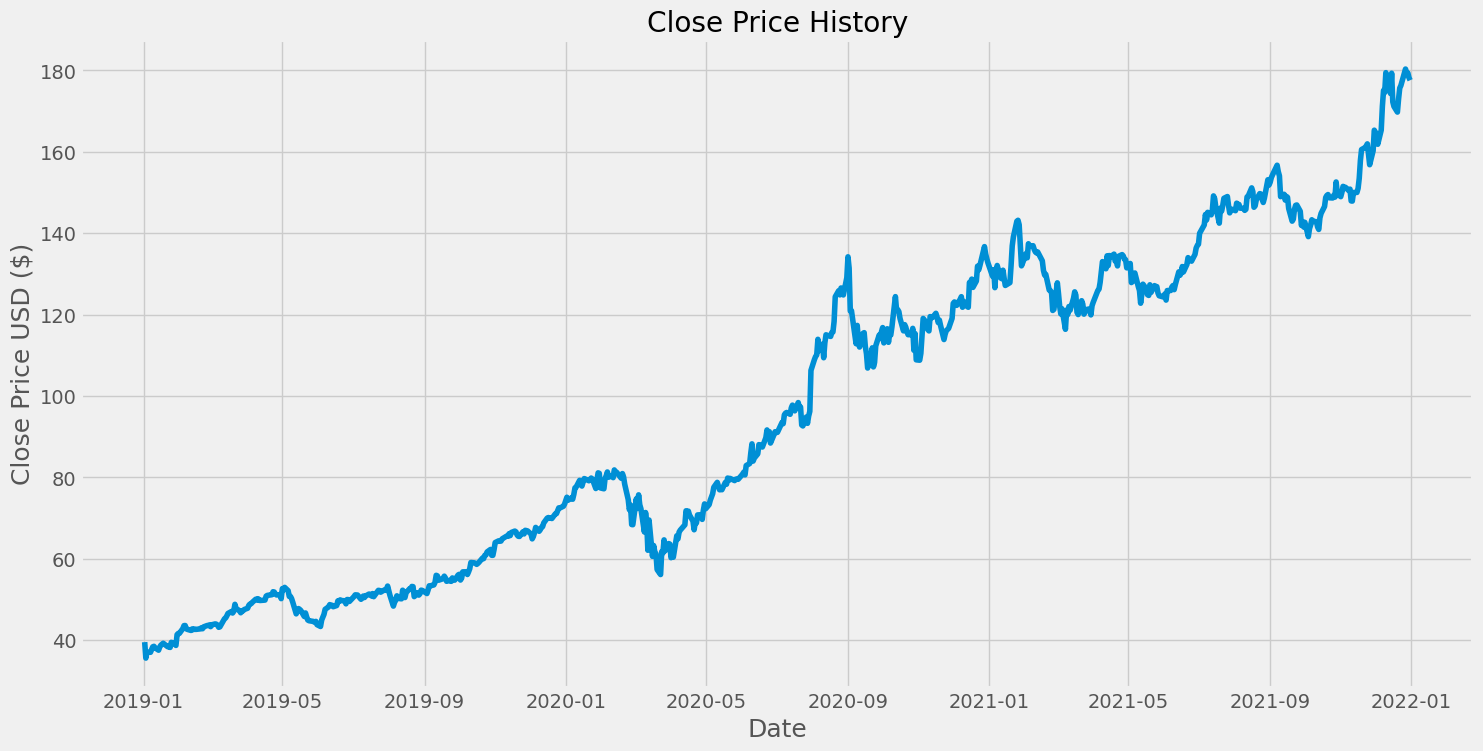

In [8]:
# let's plot the close price from 2019 to 2022
df_2019_2022 = df.loc['2019-01-01':'2022-01-01']
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df_2019_2022['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

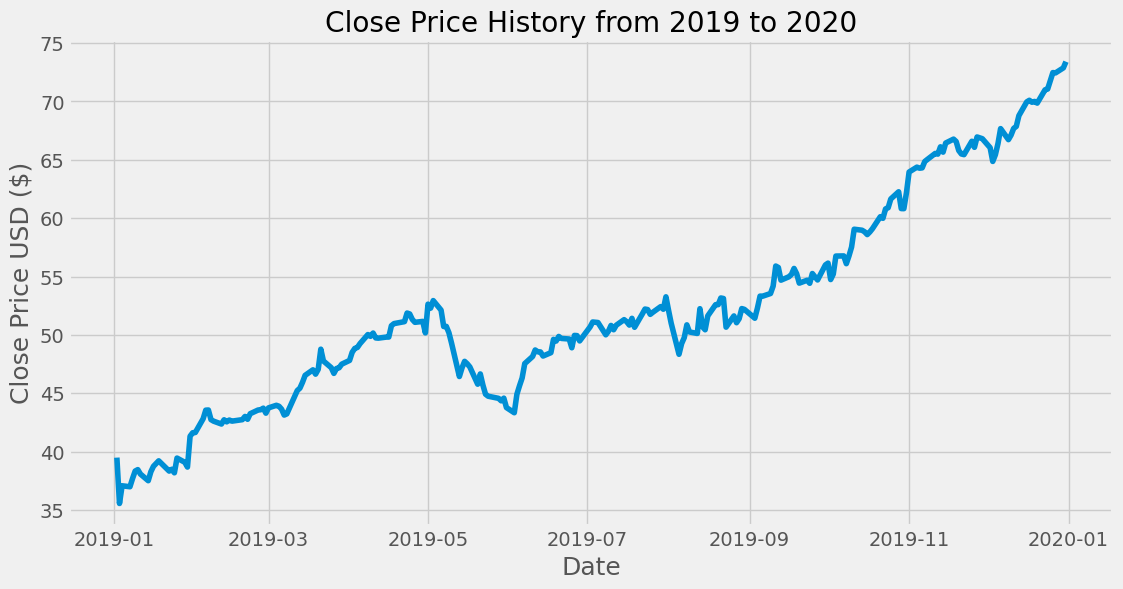

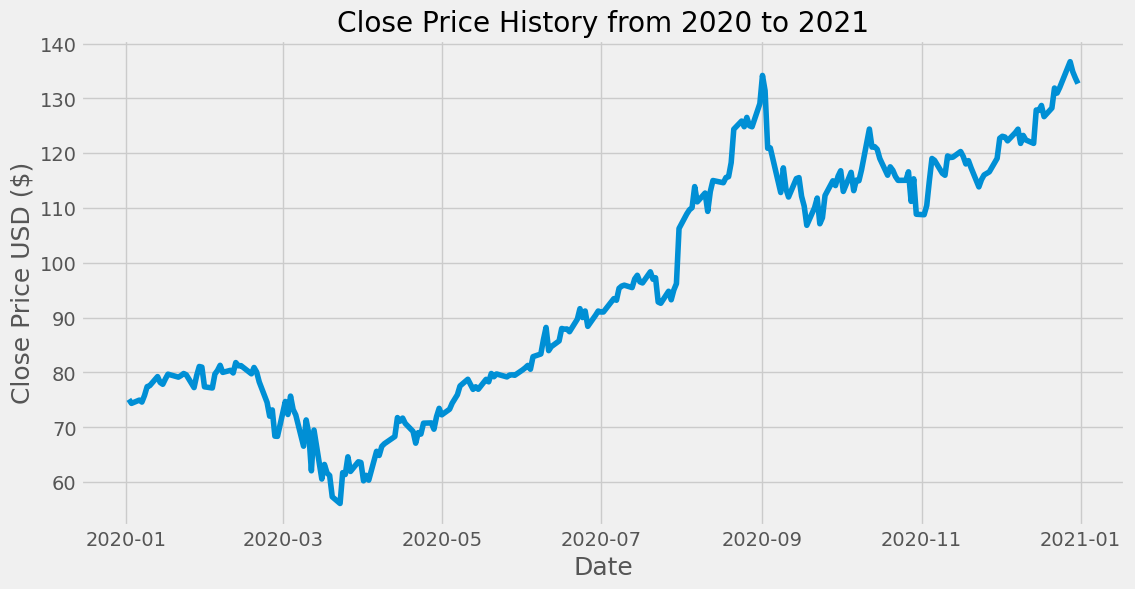

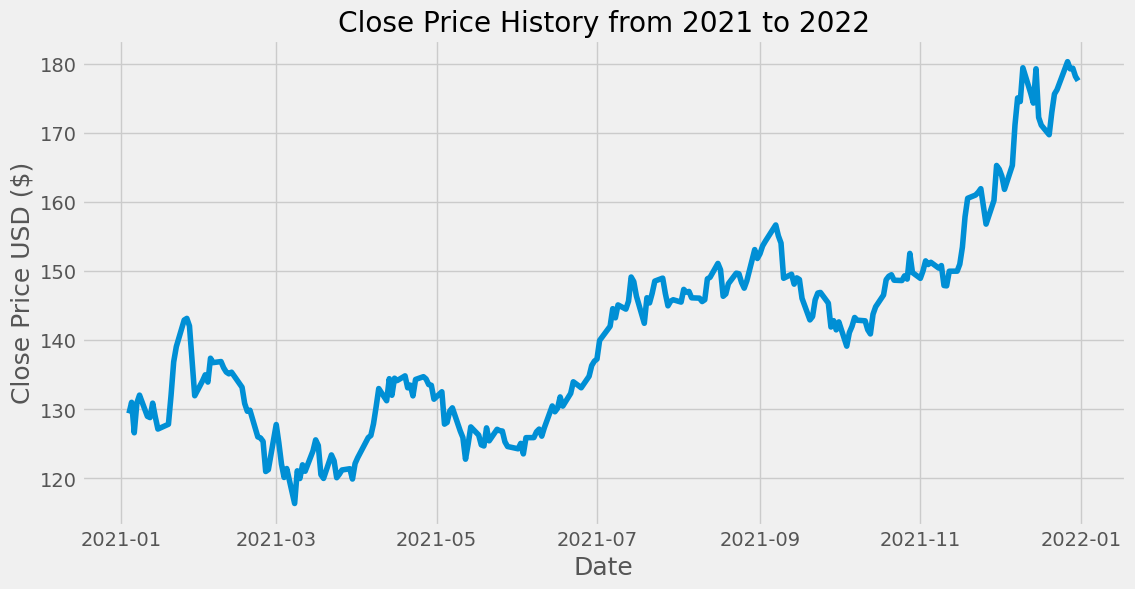

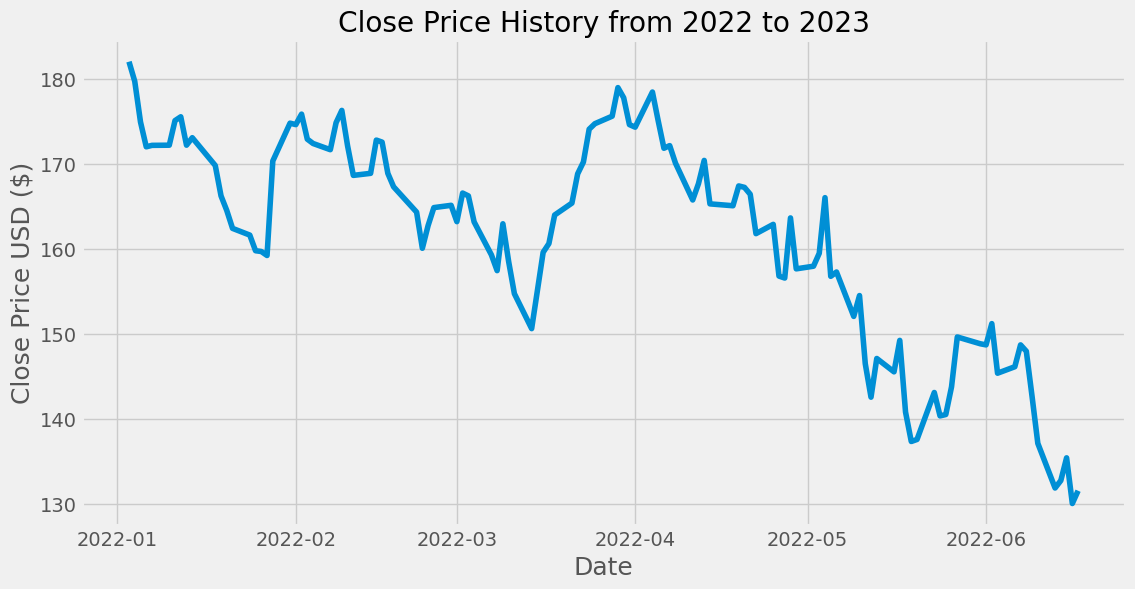

In [9]:
# let's plot the close price for each year from 2019 to 2022
for year in range(2019, 2023):
    df_year = df.loc[str(year)+'-01-01':str(year+1)+'-01-01']
    plt.figure(figsize=(12,6))
    plt.title('Close Price History from '+str(year)+' to '+str(year+1))
    plt.plot(df_year['Close'])
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close Price USD ($)', fontsize=18)
    plt.show()

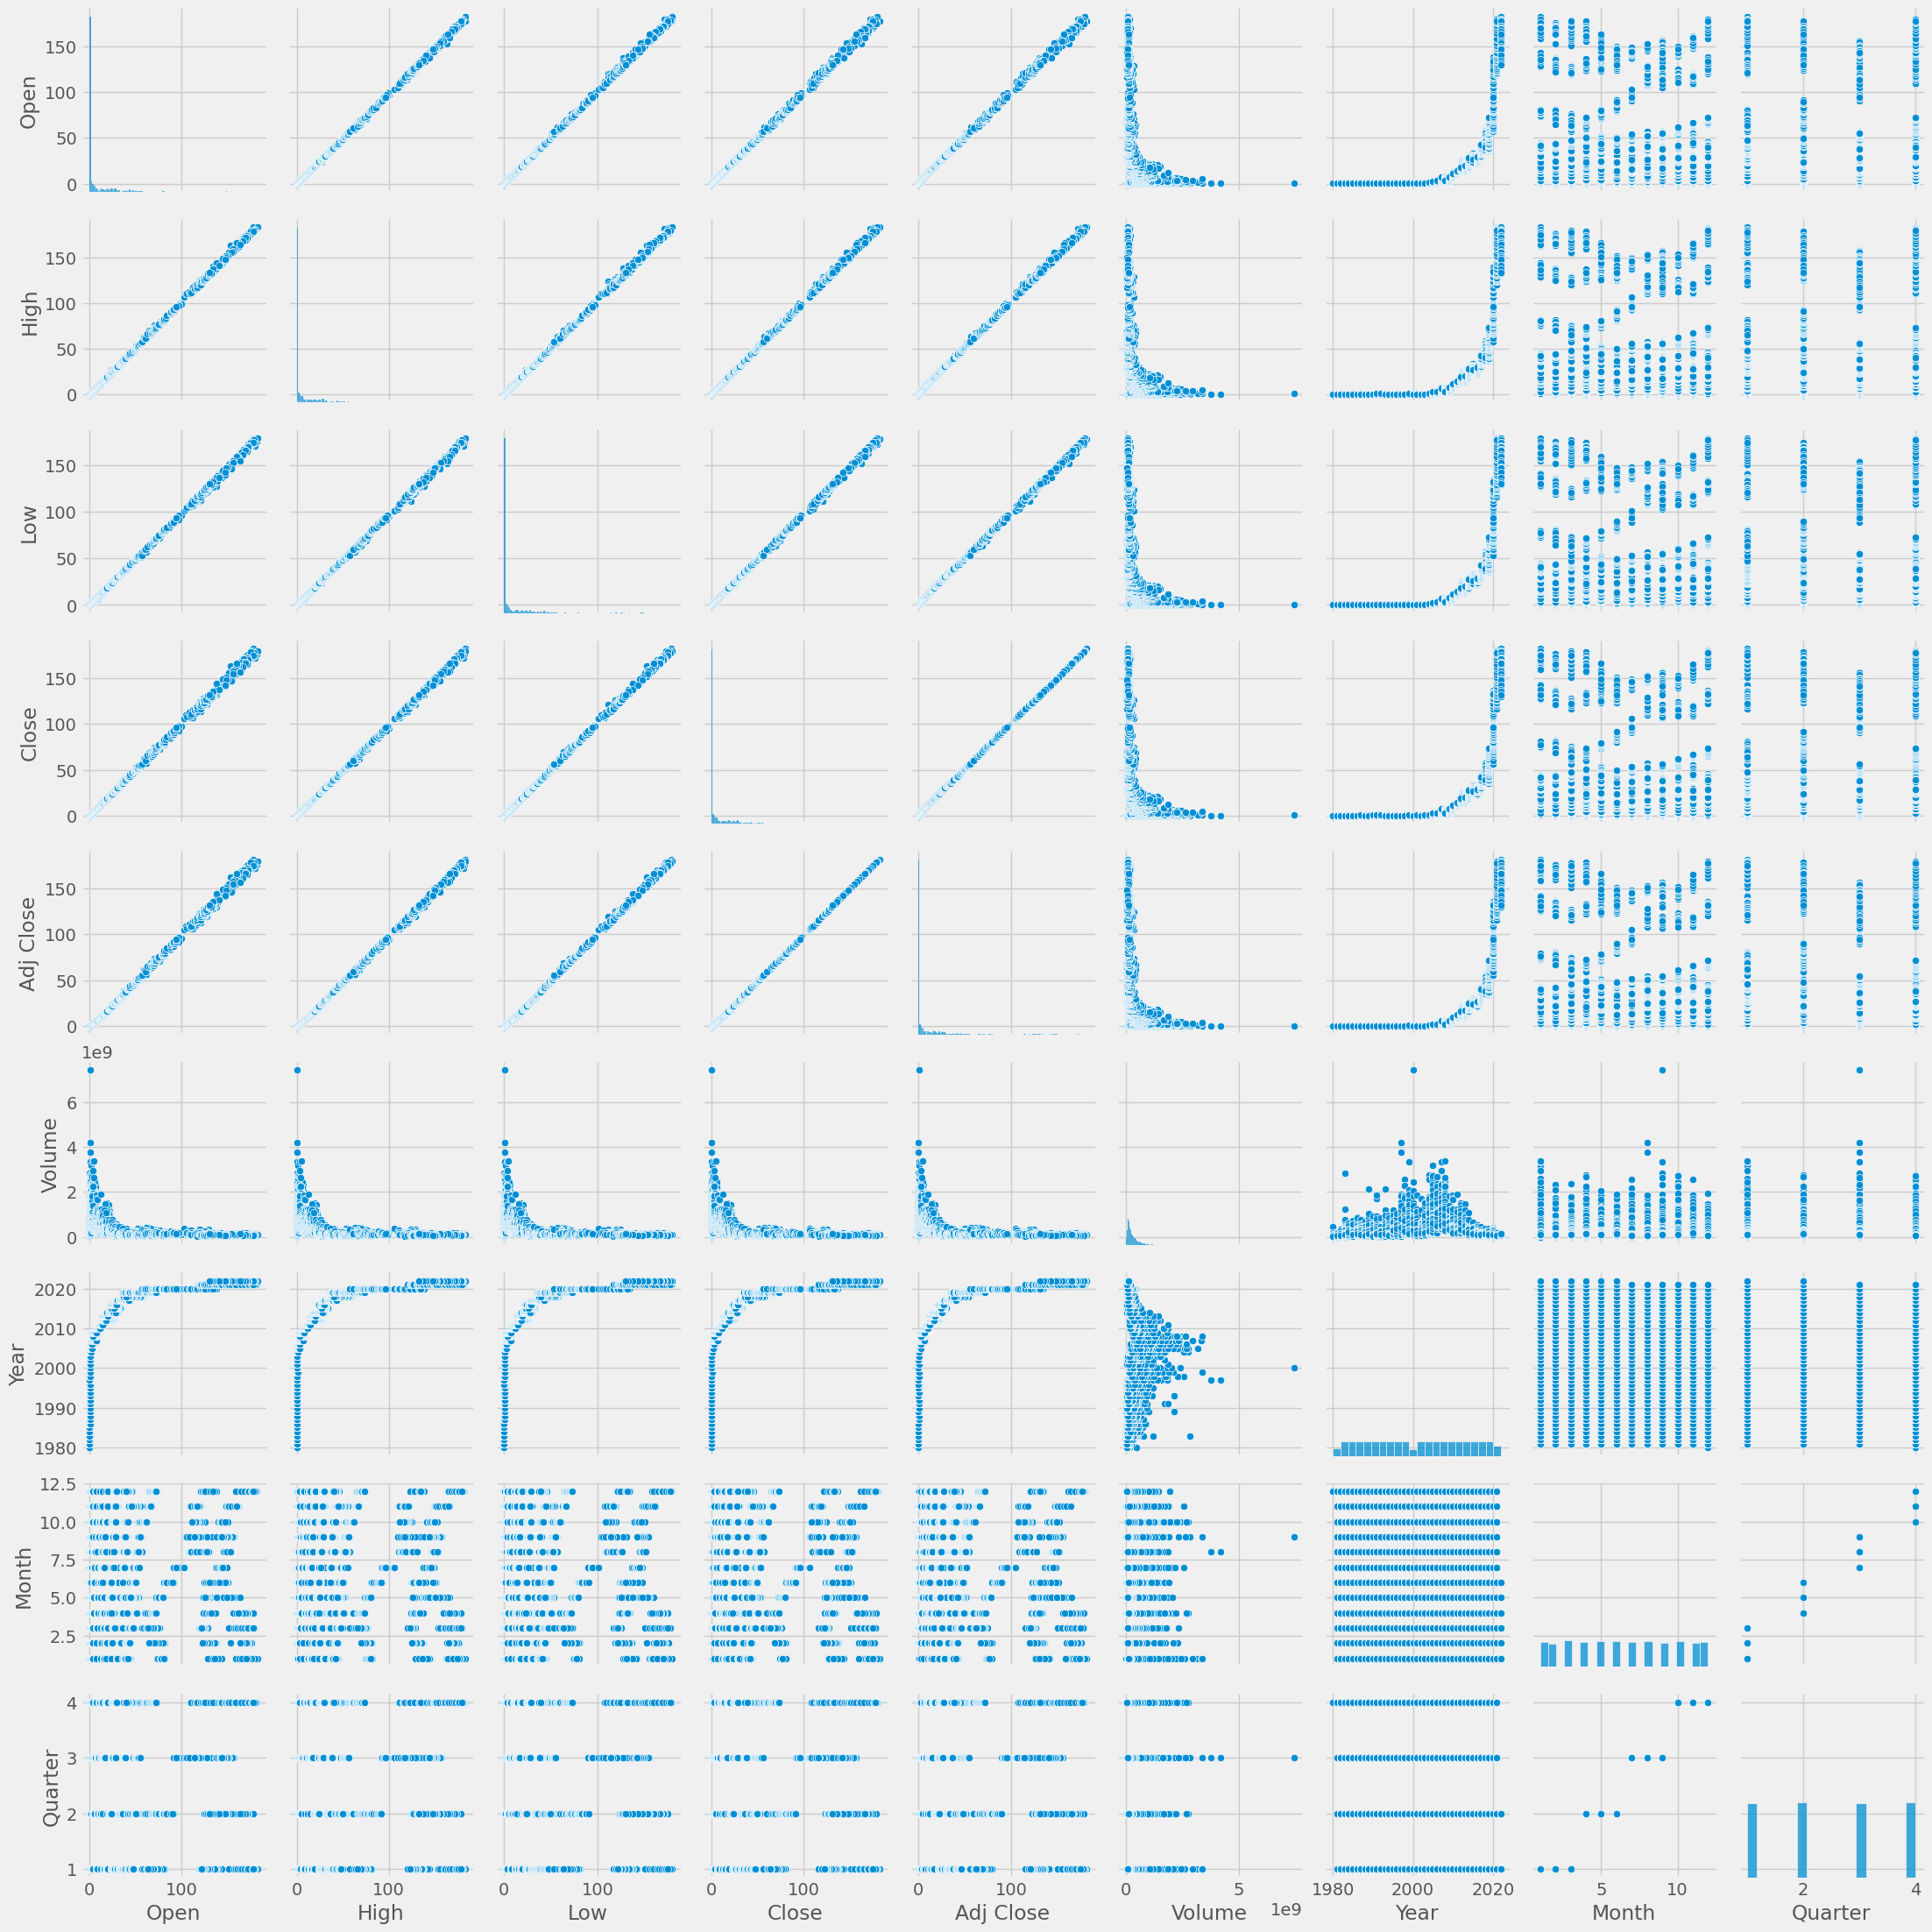

In [15]:
# let's plot a pairplot
sns.pairplot(df)
plt.show()

In [17]:
df = df.reset_index()
df = df.rename(columns={'Date':'ds', 'Close':'y'})
df = df[['ds', 'y']]

In [18]:
df = df.loc[df['ds'] >= '2020-01-01']
print("the head of the data is:")
print(df.head())

the head of the data is:
             ds          y
9847 2020-01-02  75.087502
9848 2020-01-03  74.357498
9849 2020-01-06  74.949997
9850 2020-01-07  74.597504
9851 2020-01-08  75.797501


In [19]:
scaler = MinMaxScaler()
df['y'] = scaler.fit_transform(df['y'].values.reshape(-1,1))

In [20]:
train_df = df.loc[df['ds'] <= '2021-12-31']
test_df = df.loc[df['ds'] > '2021-12-31']

In [21]:
%%time
# let's create the Prophet model
model = Prophet()
model.fit(train_df)

23:59:14 - cmdstanpy - INFO - Chain [1] start processing
23:59:14 - cmdstanpy - INFO - Chain [1] done processing


CPU times: user 147 ms, sys: 31.3 ms, total: 178 ms
Wall time: 381 ms


In [22]:
predicitions = model.predict(test_df)

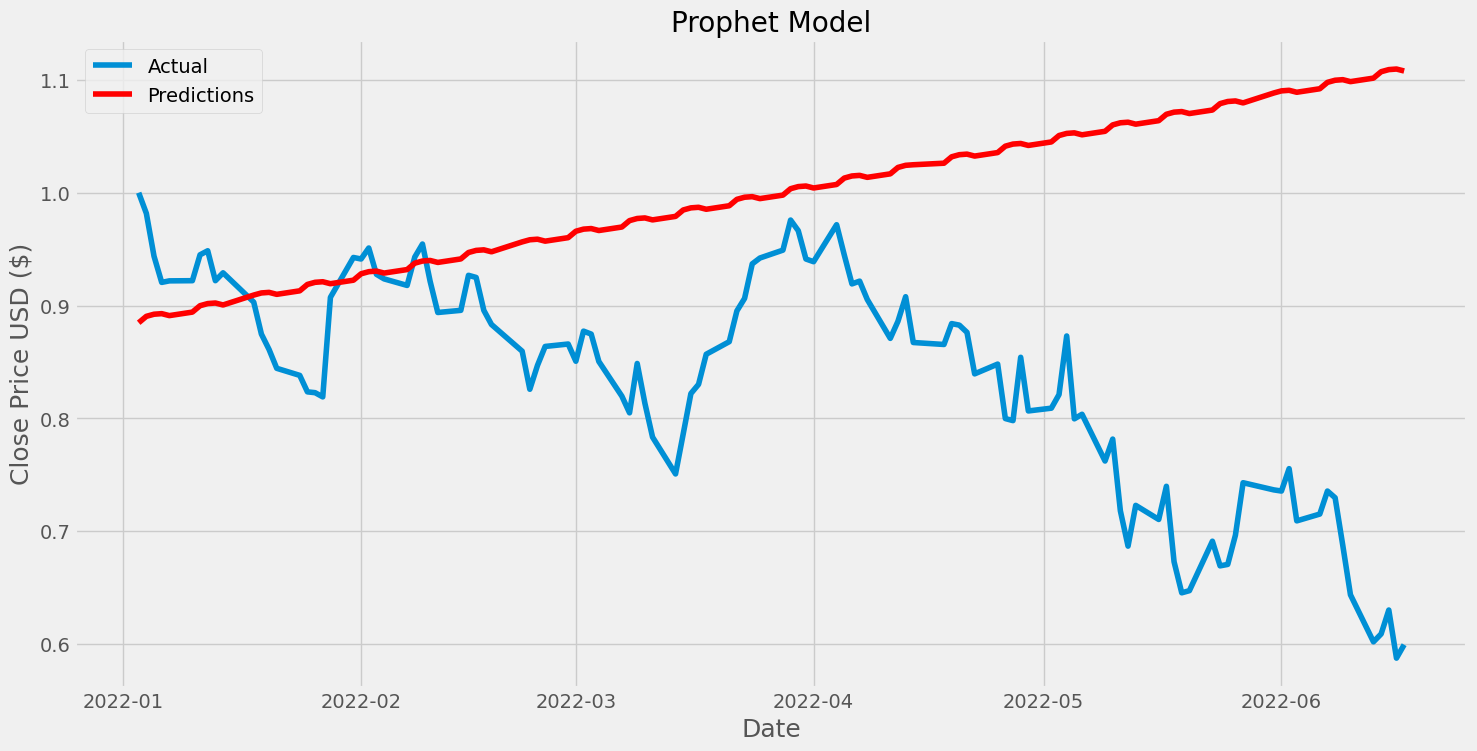

In [23]:
# predictions and the actual values
plt.figure(figsize=(16,8))
plt.title('Prophet Model')
plt.plot(test_df['ds'], test_df['y'], label='Actual')
plt.plot(test_df['ds'], predicitions['yhat'], label='Predictions', color='red')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.legend()
plt.show()